# Biological insights from 108 schizophrenia-associated loci

[PMID:25056061](https://www.ncbi.nlm.nih.gov/pubmed/25056061)

This study is one of the largest genome-wide association studies in the field of schizophrenia, with a cohort of about 150,000 individuals (36,989 cases and 113,075 controls). The study identified 108 genetic loci associated with schizophrenia. Here, we showed a simple network-based approach to facilitate the interpretation of genes associated with these loci.

## Retrieve the corresponding study from GWAS Catalog

The [GWAS Catalog](https://www.ebi.ac.uk/gwas/) is an online database of all published genome-wide association studies. We first downloaded a full copy of GWAS Catalog using the following code block.

In [1]:
%matplotlib inline
import os
from collections import defaultdict, Counter
import requests
from src import misc
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import json
import pickle
from datetime import date

url = 'https://www.ebi.ac.uk/gwas/api/search/downloads/full'

project_directory = '/projects/ooihs/ReNet/'
data_directory = os.path.join(project_directory, 'data/gwas')
if not os.path.exists(data_directory):
    os.makedirs(data_directory)
    
try:
    req = requests.get(url, stream=True)
    req.raise_for_status()

    # default name
    filename = 'gwas_' + date.today().strftime('%d%m%Y') + '.tsv'
    output_file = os.path.join(data_directory, filename)
    # use the file attachment name if presented
    for term in req.headers['content-disposition'].split(';'):
        term = term.strip()
        if term.startswith('filename='):
            output_file = os.path.join(data_directory, 
                                       term.split('=')[1].strip('"'))

    with open(output_file, 'wb') as ofh:
        for chunk in req.iter_content(chunk_size=1024):
            ofh.write(chunk)
    print('Downloaded', output_file)
    req.close()
except:
    print("Error in downloading GWAS associations")

Downloaded /projects/ooihs/ReNet/data/gwas/gwas_catalog_v1.0-associations_e90_r2017-11-20.tsv


The downloaded file is a tab-separated file with the following columns. The complete description can be found [online](https://www.ebi.ac.uk/gwas/docs/fileheaders).

We will use the second column (PUBMEDID) to extract the study and 14-th column (REPORTED GENE(S)) to extract the corresponding genes.

In [2]:
!head -n 1 {output_file}

## Extract the reported genes and convert to Uniprot accessions

From the download file, we extracted the associations based on the `PUBMEDID` (`25056061`). An association might contain multiple associated genes. Finally, we converted the associated genes to the corresponding proteins based on the `HGNC`. Not, not all entries will be converted. For example, the `MIR137` microRNA will not be converted.

In [3]:
# only genes from REPORTED GENE(S) (14-th column) will be used.
szgenes = set()
with open(output_file) as ifh:
    for line in ifh:
        col = line.strip().split('\t')
        
        if col[1].strip() == '25056061':
            # REPORTED GENE(S) are splitted by ,
            szgenes.update([g.strip() for g in col[13].split(',')])
            
print('Total number of items loaded:', len(szgenes))


hgnc_file = os.path.join(project_directory, 'data/hgnc/hgnc_complete_set.json')
hgnc = misc.load_hgnc_json(hgnc_file)

# build a gene symbol to uniprot mapping
gene2uniprot = {}
for item in hgnc['uniprot']:
    gene2uniprot[hgnc['uniprot'][item]] = item
    
# convert the szgenes to szproteins
szproteins = set([gene2uniprot[gene] for gene in szgenes if gene in gene2uniprot])

background_proteins = list(hgnc['uniprot'].keys())

print('Total number of proteins obtained:', len(szproteins))

Total number of items loaded: 305
Total number of proteins obtained: 280


## Construct schizophrenia-associated network from the selected proteins

Given the selected proteins, we can build a schizophrenia-associated network by identifying known interactions between the proteins. There are several ways to build an interaction network from the selected proteins. For example, we could build a zeroth order network that only captures interactions between the selected proteins, or a first-order network that captures interactions between the selected proteins and other proteins.

Here, a zeroth order network is built.

### Load the global interaction network

We first load the integrated network obtained from [Data integration](Data integration.ipybn) section. We also recorded the likelihood of each interaction.

In [4]:
# load global network
def load_network(network_file, lr_cutoff=0):
    """Load the integrated network, with likelihood ratio"""
    graph = nx.Graph()
    with open(network_file) as ifh:
        for line in ifh:
            col = line.strip().split('\t')
            info = json.loads(col[2])
            if info['lr'] >= lr_cutoff:
                graph.add_edge(col[0], col[1], lr=info['lr'])

    return graph
            
network_file = os.path.join(project_directory, 'results/final/integrated.network.uniprot')
network = load_network(network_file)
print('Network loaded:')
print('Proteins:', network.number_of_nodes())
print('Interactions:', network.number_of_edges())
print('Connected components:', nx.number_connected_components(network))
# serialize the network to a file for more efficient loading
pickled_file = network_file + '.pickle'
pickle.dump(network, open(pickled_file, 'wb'))

Network loaded:
Proteins: 19185
Interactions: 1231170
Connected components: 1


### Build the schizophrenia-associated network from schizophrenia-associated proteins

The schizophrenia-associated network is built by first adding all the selected proteins, followed by all direct interactions between these proteins.

In [5]:
sznet = nx.Graph()
sznet.add_nodes_from(szproteins)    
sznet.add_edges_from(network.subgraph(szproteins).edges())
print('Schizophrenia-associated network loaded:')
print('Proteins:', sznet.number_of_nodes())
print('Interactions:', sznet.number_of_edges())
print('Connected components:', nx.number_connected_components(sznet))

Schizophrenia-associated network loaded:
Proteins: 280
Interactions: 370
Connected components: 106


### Is the schizophrenia-associated network significant?

The schizophrenia-associated network is constructed based on direct interactions between two schizophrenia-associated proteins. The more connected these proteins, the more likely they involved in the same disease mechanism that underlying schizophrenia.

Therefore, the first question to ask is whether the constructed network is significantly differed from other networks. We performed a permutation test to test the hypothesis. In this case, the null hypothesis states that any randomly selected set of proteins (of the same size as the szproteins) will be able to generate a network of similar size.

Here, we used test statistics such as the number of proteins involved in the network and their interactions.

Test statistics for the largest subnet of schizophrenia-associated network
Proteins: 167
Interactions: 361
Diameter: 8


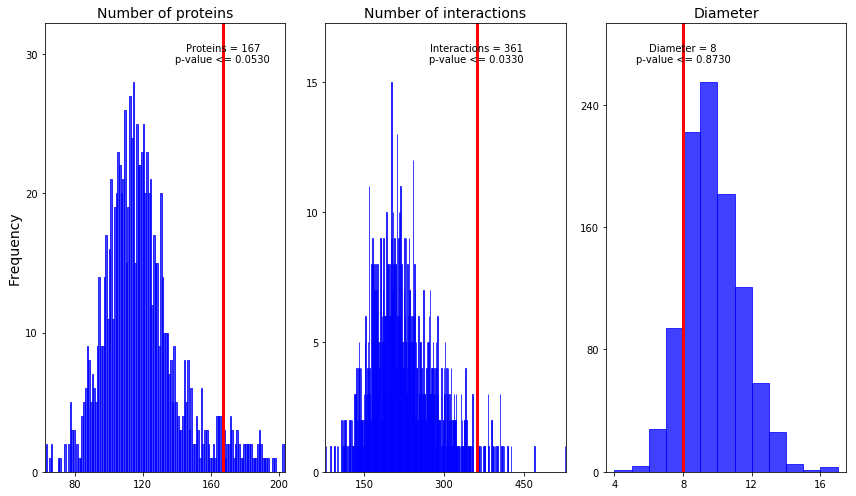

In [6]:
test = {}

# test statistics is based on the largest connected component
sznet_subnet = max(nx.connected_component_subgraphs(sznet), key=len)
test['nodes'] = sznet_subnet.number_of_nodes()
test['edges'] = sznet_subnet.number_of_edges()
test['diameter'] = nx.diameter(sznet_subnet)

print('Test statistics for the largest subnet of schizophrenia-associated network')
print('Proteins:', test['nodes'])
print('Interactions:', test['edges'])
print('Diameter:', test['diameter'])


def test_network(args):    
    """get the properties of a random network draw from the network_file
    with the proteins of protein_size"""
    random_seed, protein_size, network_file, background_list = args
    
    # build the network 
    network = pickle.load(open(network_file, 'rb'))
            
    np.random.seed(random_seed)
    # randomly select the proteins without replacement
    rproteins = np.random.choice(background_list, protein_size, replace=False)
    rnet = nx.Graph()
    rnet.add_nodes_from(rproteins)
    rnet.add_edges_from(network.subgraph(rproteins).edges())
    
    subnet = max(nx.connected_component_subgraphs(rnet), key=len)
    node_size = subnet.number_of_nodes()
    edge_size = subnet.number_of_edges()
    diameter = nx.diameter(subnet)
    return (node_size, edge_size, diameter)


def network_permuation_test(num_permutation, test_stat, protein_size, network_file, background_list, output_figure, number_of_workers=1):
    """perform a permutation on the network properties"""

    # execute the job parallely
    process_list = []
    for i in range(num_permutation):
        process_list.append((i+108, protein_size, network_file, background_list))
    
    pool = multiprocessing.Pool(number_of_workers)
    info = pool.imap_unordered(test_network, process_list)

    pool.close()
    pool.join()

    # collect the run statistics
    node_count = np.zeros(num_permutation)
    edge_count = np.zeros(num_permutation)
    diameter_count = np.zeros(num_permutation)

    for i, item in enumerate(info):
        n, e, d = item
        node_count[i] = n
        edge_count[i] = e 
        diameter_count[i] = d

    # calculate the p-values and plot the graph
    # generally, we cannot have an empirical p-value of 0, as we only draw
    # a subset of all possible combinations for the permutation test
    node_pvalue = 1.0/num_permutation
    # calculate the empirical p-value based on the number of oberserved
    # events
    if not all(node_count < test_stat['nodes']):
        observed = np.size(np.where(node_count >= test_stat['nodes']))
        node_pvalue = np.float(observed)/num_permutation

    edge_pvalue = 1.0/num_permutation
    if not all(edge_count < test_stat['edges']):
        observed = np.size(np.where(edge_count >= test_stat['edges']))
        edge_pvalue = np.float(observed)/num_permutation
        
    # for connected component, lesser is better
    diameter_pvalue = 1.0/num_permutation
    if not all(diameter_count < test_stat['diameter']):
        observed = np.size(np.where(diameter_count >= test_stat['diameter']))
        diameter_pvalue = np.float(observed)/num_permutation
        
        
    # figure of size 12x8 inches
    fig, ax = plt.subplots(1, 3, figsize=(12, 7))
    
    # plot the proteins distribution
    data_range = max(node_count) - min(node_count)
    # draw histogram
    freq, bins, patches = ax[0].hist(node_count, np.int(data_range),
                                    facecolor='b', edgecolor='b',
                                    alpha=0.75, color='b')
    max_freq = max(freq)
    # draw the test statistic, and provide some description
    ax[0].axvline(test_stat['nodes'], linewidth=3, color='r')
    ax[0].text(test_stat['nodes'], 1.05*np.float(max_freq),
              ('Proteins = {}'.format(test_stat['nodes']) + 
               '\np-value <= {:.4f}'.format(node_pvalue)),
              horizontalalignment='center', fontsize=10)
    
    # adjust the axes
    ax[0].set_title('Number of proteins', fontsize=14)
    ax[0].set_ylim(0, max_freq*1.15)
    yticks = plt.MaxNLocator(4)
    ax[0].yaxis.set_major_locator(yticks)
    ax[0].set_ylabel('Frequency', fontsize=14)
    
    max_bins = max([max(bins), test_stat['nodes']])
    ax[0].set_xlim(min(bins)-0.5, max_bins+0.5)
    xticks = plt.MaxNLocator(4)
    ax[0].xaxis.set_major_locator(xticks)
    
    # plot the interactions distribution
    data_range = max(edge_count) - min(edge_count)
    freq, bins, patches = ax[1].hist(edge_count, np.int(data_range),
                                    facecolor='b', edgecolor='b',
                                    alpha=0.75, color='b')
    max_freq = max(freq)    
    ax[1].axvline(test_stat['edges'], linewidth=3, color='r')    
    ax[1].text(test_stat['edges'], 1.05*np.float(max_freq),
              ('Interactions = {}'.format(test_stat['edges']) + 
               '\np-value <= {:.4f}'.format(edge_pvalue)),
              horizontalalignment='center', fontsize=10)
        
    ax[1].set_title('Number of interactions', fontsize=14)
    ax[1].set_ylim(0, max_freq*1.15)
    yticks = plt.MaxNLocator(4)
    ax[1].yaxis.set_major_locator(yticks)
    # only needs to label on one side
    #ax[1].set_ylabel('Frequency', fontsize=14)
    
    max_bins = max([max(bins), test_stat['edges']])
    ax[1].set_xlim(min(bins)-0.5, max_bins+0.5)
    xticks = plt.MaxNLocator(4)
    ax[1].xaxis.set_major_locator(xticks)


    # plot the connected components distribution
    data_range = max(diameter_count) - min(diameter_count)
    freq, bins, patches = ax[2].hist(diameter_count, np.int(data_range),
                                    facecolor='b', edgecolor='b',
                                    alpha=0.75, color='b')
    max_freq = max(freq)    
    ax[2].axvline(test_stat['diameter'], linewidth=3, color='r')    
    ax[2].text(test_stat['diameter'], 1.05*np.float(max_freq),
              ('Diameter = {}'.format(test_stat['diameter']) + 
               '\np-value <= {:.4f}'.format(diameter_pvalue)),
              horizontalalignment='center', fontsize=10)
        
    ax[2].set_title('Diameter', fontsize=14)
    ax[2].set_ylim(0, max_freq*1.15)
    yticks = plt.MaxNLocator(4)
    ax[2].yaxis.set_major_locator(yticks)
    # only needs to label on one side
    #ax[2].set_ylabel('Frequency', fontsize=14)
    
    max_bins = max([max(bins), test_stat['diameter']])
    ax[2].set_xlim(min(bins)-0.5, max_bins+0.5)
    xticks = plt.MaxNLocator(4)
    ax[2].xaxis.set_major_locator(xticks)
    
    fig.tight_layout()
    fig.savefig(output_figure, dpi=300)
    plt.show()
    plt.close(fig)
                
# for demonstration purpose, we set the number of permutation to 1000, in 
# reality, it is better to set it to at least 10,000
num_permutation = 1000

image_file = os.path.join(project_directory, 'results/images/permutation_test_all.png')
network_permuation_test(num_permutation, test, len(szproteins), pickled_file,
                        background_proteins, image_file, 20)


### Over-Representation Analysis (ORA) of the schizophrenia-associated network

The schizophrenia-associated network generally contains schizophrenia-associated proteins participated in direct interactions. Therefore, they could form important parts of the disease mechanism underlying schizophrenia. 

We subjected the set of proteins in the schizophrenia-associated network to the enrichment analysis using the hypergeometric test.

In [7]:
from src import ora

kegg_file = os.path.join(project_directory, 'results/map/pathway.kegg.uniprot')
result = ora.network_test(sznet_subnet, kegg_file, len(background_proteins))
result

,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
0,hsa05010,Alzheimer's disease,0.000002,0.000340,10/167,171/20030
1,hsa04723,Retrograde endocannabinoid signaling,0.000004,0.000412,9/167,148/20030
2,hsa04720,Long-term potentiation,0.000020,0.001294,6/167,67/20030
3,hsa04024,cAMP signaling pathway,0.000044,0.002114,9/167,198/20030
4,hsa04015,Rap1 signaling pathway,0.000069,0.002667,9/167,210/20030
5,hsa04728,Dopaminergic synapse,0.000110,0.003552,7/167,130/20030
6,hsa04261,Adrenergic signaling in cardiomyocytes,0.000208,0.005745,7/167,144/20030
7,hsa04520,Adherens junction,0.000338,0.007173,5/167,72/20030
8,hsa04725,Cholinergic synapse,0.000354,0.007173,6/167,112/20030
9,hsa04724,Glutamatergic synapse,0.000372,0.007173,6/167,113/20030


### Cross-check using DAVID

The following performed the over-representation analysis using DAVID. Click on the link generated to see the result. Generally, besides slightly different p-values, both tools show similar results.

In [8]:
annotations = ['KEGG_PATHWAY']
url = 'https://david.ncifcrf.gov/api.jsp?type=UNIPROT_ACCESSION&ids={protein_list}&tool=chartReport&annot={annot_list}'

print(url.format(protein_list=','.join(sznet_subnet.nodes()), annot_list=','.join(annotations)))

https://david.ncifcrf.gov/api.jsp?type=UNIPROT_ACCESSION&ids=Q9P0J0,Q96GW9,Q9C0K0,Q96BI3,Q00722,Q53GL0,Q13618,Q9H8M1,Q92686,Q9UL54,P07332,Q96MF2,Q9NRW7,Q7Z5J4,Q96BT3,O60716,Q6Y7W6,P32297,P18146,Q04724,Q15008,P16333,P21246,Q9H0I2,Q2NL82,Q9ULX7,Q66PJ3,O60741,Q969R5,Q9NQU5,Q07866,Q14832,P34897,Q9BYU1,O15090,P17050,Q15542,Q86UR5,Q86YP4,Q9UPW6,Q8N5M1,Q6U841,P36956,Q96RJ3,P40313,P61970,Q9UP95,O43147,Q9H598,P49902,Q04726,Q9H9F9,P36405,Q9UHF0,Q96DA6,Q8NG27,Q8WXI2,Q6VN20,Q6I9Y2,Q9HCI7,Q9BW71,Q3KR37,Q8NBZ0,Q96NS1,Q9Y320,Q8WZ19,Q86XT9,Q96D15,P46060,Q9GZT4,Q96IL0,P30307,Q7Z570,Q14624,Q9C0B5,Q07954,P34913,Q86US8,Q92989,O43542,P51114,Q9NVC3,Q9H4I9,Q13936,P16615,P42226,P09958,Q8WVM7,O75164,Q9BTT0,Q15742,Q9H857,P35221,P10809,Q6P1R3,P10909,Q14690,Q9NRX3,Q9NPB6,Q08289,Q12772,P56556,Q96AP0,Q6ICG8,Q9Y314,Q9H7N4,Q6P2E9,P40306,Q99550,P78362,Q8IWZ8,A0JLT2,Q06033,B8ZZ34,P30926,A5YKK6,Q9Y243,P60510,Q09472,P25789,Q9UL15,Q12968,P30532,O75533,P14416,Q86U86,P42261,Q15139,Q6ZVM7,Q06190,O75912,P61236,P11801,P38646,P

### How many of these enriched pathways have been associated with schizophrenia?

Many of the observed pathways have been reported to be associated with schizophrenia, for example, Long-term potentiation, Dopaminergic and Glutamatergic synapse, etc. Here, we performed a simple check using the abstracts from the PUBMED collection. We first queried articles associated with schizophrenia using the query term `(schizophrenia[MeSH Terms]) OR (schizophrenia[Title/Abstract])`. We then checked the occurrences of KEGG pathways in the abstracts of these articles. Finally, we updated the result table with the number of occurrences of the KEGG pathways in the PUBMED abstracts. 

In [9]:
from src import pubmed

def check_term_in_file(input_file, term):
    pmids = set()

    with open(input_file) as fh:
        for line in fh:
            if line.startswith('#'):
                continue

            if term.lower() in line.lower():
                pmids.add(line.strip().split('\t')[0]) # add in the pmid

    return pmids

def build_kegg_article(input_file, pubmed_file, output_file):
    count = [0, 0]
    with open(output_file, 'w') as ofh:
        with open(input_file) as fh:
            for line in fh:
                if line.startswith('#'):
                    continue
                pname = line.strip().split('\t')[1]
                pname = pname[:pname.find(' - Homo sapiens (human)')]
                pmid_list = check_term_in_file(pubmed_file, pname)
                ofh.write('%s\t%d\t%s\n' % (pname, len(pmid_list), '\t'.join(pmid_list)))
                count[0] += 1
                if len(pmid_list) > 0:
                    count[1] += 1

    print('Constructing KEGG pathway occurrences in Schizophrenia associated articles')
    print('Total number of profiles processed:', count[0])
    print('Total number of profiles associated with article:', count[1])

    
final_directory = os.path.join(project_directory, 'results/final/'    )
pubmed_file = os.path.join(final_directory, 'pubmed_schizophrenia_articles.txt')
if not os.path.isfile(pubmed_file):
    pubmed.query(pubmed_file, 
                 '(schizophrenia[MeSH Terms]) OR (schizophrenia[Title/Abstract])',
                 5000)
    
article_file = os.path.join(final_directory, 'kegg_in_schizophrenia_articles.txt')
if not os.path.isfile(article_file):
    build_kegg_article(kegg_file, pubmed_file, article_file)
    
kegg_pubmed = {}
with open(article_file) as ifh:
    for line in ifh:
        col = line.strip().split('\t')
        kegg_pubmed[col[0]] = int(col[1])
        
result['Pubmed articles'] = [kegg_pubmed.get(pathway) for pathway in result['Name']]
result

Total number of records to download: 127847
... Downloading record 5001 to 10000
... Downloading record 10001 to 15000
... Downloading record 15001 to 20000
... Downloading record 20001 to 25000
... Downloading record 25001 to 30000
... Downloading record 30001 to 35000
... Downloading record 35001 to 40000
... Downloading record 40001 to 45000
... Downloading record 45001 to 50000
... Downloading record 50001 to 55000
... Downloading record 55001 to 60000
... Downloading record 60001 to 65000
... Downloading record 65001 to 70000
... Downloading record 70001 to 75000
... Downloading record 75001 to 80000
... Downloading record 80001 to 85000
... Downloading record 85001 to 90000
... Downloading record 90001 to 95000
... Downloading record 95001 to 100000
... Downloading record 100001 to 105000
... Downloading record 105001 to 110000
... Downloading record 110001 to 115000
... Downloading record 115001 to 120000
... Downloading record 120001 to 125000
... Downloading record 125001 to 1

,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome,Pubmed articles
0,hsa05010,Alzheimer's disease,0.000002,0.000340,10/167,171/20030,1859
1,hsa04723,Retrograde endocannabinoid signaling,0.000004,0.000412,9/167,148/20030,0
2,hsa04720,Long-term potentiation,0.000020,0.001294,6/167,67/20030,230
3,hsa04024,cAMP signaling pathway,0.000044,0.002114,9/167,198/20030,4
4,hsa04015,Rap1 signaling pathway,0.000069,0.002667,9/167,210/20030,0
5,hsa04728,Dopaminergic synapse,0.000110,0.003552,7/167,130/20030,12
6,hsa04261,Adrenergic signaling in cardiomyocytes,0.000208,0.005745,7/167,144/20030,0
7,hsa04520,Adherens junction,0.000338,0.007173,5/167,72/20030,4
8,hsa04725,Cholinergic synapse,0.000354,0.007173,6/167,112/20030,5
9,hsa04724,Glutamatergic synapse,0.000372,0.007173,6/167,113/20030,85


## Increase the network reliability

The global interaction network may still contain false-positive interactions. We could use the associated likelihood ratio to filter unreliable interactions. Generally, an interaction with a likelihood ratio with at least 1 means that the interaction is more likely to occur according to the collected data sources. Therefore, we constructed a network with all interactions with likelihood ratios >= 1, and followed the same analysis.

Network loaded:
Proteins: 16498
Interactions: 411188
Connected components: 19

Schizophrenia-associated network loaded:
Proteins: 280
Interactions: 127
Connected components: 175

Test statistics for the largest subnet of schizophrenia-associated network
Proteins: 73
Interactions: 87
Diameter: 10



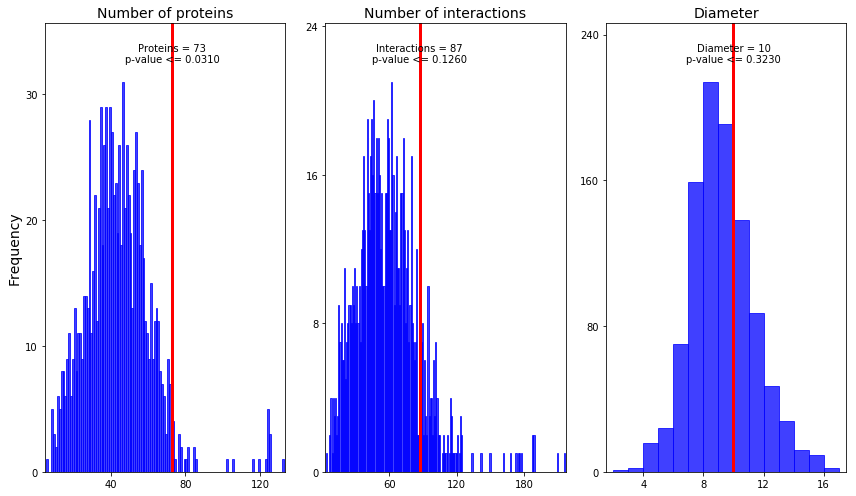

,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome,Pubmed articles
0,hsa04520,Adherens junction,0.000138,0.019805,4/73,72/20030,4
1,hsa04360,Axon guidance,0.000435,0.028144,5/73,174/20030,45
2,hsa03050,Proteasome,0.000590,0.028144,3/73,45/20030,32


In [10]:
network_file = os.path.join(project_directory, 'results/final/integrated.network.uniprot')
# load the network with likelihood ratio >= 1.0
network = load_network(network_file, 1.0)
print('Network loaded:')
print('Proteins:', network.number_of_nodes())
print('Interactions:', network.number_of_edges())
print('Connected components:', nx.number_connected_components(network))
print()

# serialize the network to a file for more efficient loading
pickled_file = network_file + '.filtered.pickle'
pickle.dump(network, open(pickled_file, 'wb'))

# build the schizophrenia-associated subnetwork
sznet = nx.Graph()
sznet.add_nodes_from(szproteins)    
sznet.add_edges_from(network.subgraph(szproteins).edges())
print('Schizophrenia-associated network loaded:')
print('Proteins:', sznet.number_of_nodes())
print('Interactions:', sznet.number_of_edges())
print('Connected components:', nx.number_connected_components(sznet))
print()

test = {}
# test statistics is based on the largest connected component
sznet_subnet = max(nx.connected_component_subgraphs(sznet), key=len)
test['nodes'] = sznet_subnet.number_of_nodes()
test['edges'] = sznet_subnet.number_of_edges()
test['diameter'] = nx.diameter(sznet_subnet)

print('Test statistics for the largest subnet of schizophrenia-associated network')
print('Proteins:', test['nodes'])
print('Interactions:', test['edges'])
print('Diameter:', test['diameter'])
print()

image_file = os.path.join(project_directory, 'results/images/permutation_test_filtered.png')
network_permuation_test(num_permutation, test, len(szproteins), pickled_file,
                        background_proteins, image_file, 20)

result = ora.network_test(sznet_subnet, kegg_file, len(background_proteins))
result['Pubmed articles'] = [kegg_pubmed.get(pathway) for pathway in result['Name']]
result

### Results

Generally, the number of proteins in the largest subgraph still contain significantly more proteins than random backgrounds. However, the number of interactions was not that significant, but still followed the general trend as shown in the global network. 

The list of enriched pathways is lesser, which is due to the smaller size network. However, we were still able to find some pathways have been associated with schizophrenia.

## Comparing the discovery power of individual networks

We then compared the discovery power of each original interaction network using the same method. While many of these individual networks could still find the pathways associated with schizophrenia, the resulted pathways generally were different. Therefore, using different networks for the same data analysis could be resulted in inconsistent scientific findings. 



In [11]:
from IPython.display import display, HTML

def build_subnet(network_file, proteins):
    """build a sub-network from the network_file, based on the proteins"""
    
    # load the network first
    network = nx.Graph()
    with open(network_file) as ifh:
        for line in ifh:
            col = line.strip().split('\t')
            network.add_edge(col[0], col[1])
            
    subnet = nx.Graph()
    subnet.add_nodes_from(proteins)
    subnet.add_edges_from(network.subgraph(proteins).edges())
    
    return subnet

databases = [
    'ComPPI', 'CPDB', 'FunCoup', 'GeneMANIA', 'HIPPIE', 'HumanNet', 'InBioMap',
    'IRefIndex', 'Publication', 'STRING'
]

results = {}
for db in databases:
    input_file = None
    if db == 'ReNet':
        input_file = os.path.join(project_directory, 
                                  'results/final/integrated.network.uniprot')
    else:
        input_file = os.path.join(project_directory,
                                  'results/final/score.' + db.lower())
        
    dbnet = build_subnet(input_file, szproteins)
    largest_subnet = max(nx.connected_component_subgraphs(dbnet), key=len)
    results[db] = ora.network_test(largest_subnet, kegg_file, 
                               len(background_proteins))
    results[db]['Pubmed articles'] = [kegg_pubmed.get(pathway) 
                                      for pathway in results[db]['Name']]
    display(HTML('<h3>ORA for ' + db + '</h3>'))
    display(results[db])
    

,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome,Pubmed articles


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome,Pubmed articles
0,hsa04520,Adherens junction,0.000146,0.02015,4/74,72/20030,4


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome,Pubmed articles
0,hsa04024,cAMP signaling pathway,0.000005,0.000873,8/97,198/20030,4
1,hsa04720,Long-term potentiation,0.000018,0.001481,5/97,67/20030,230
2,hsa05010,Alzheimer's disease,0.000184,0.009030,6/97,171/20030,1859
3,hsa04724,Glutamatergic synapse,0.000223,0.009030,5/97,113/20030,85
4,hsa04520,Adherens junction,0.000413,0.011156,4/97,72/20030,4
5,hsa05412,Arrhythmogenic right ventricular cardiomyopath...,0.000413,0.011156,4/97,72/20030,0
6,hsa04015,Rap1 signaling pathway,0.000553,0.011347,6/97,210/20030,0
7,hsa03018,RNA degradation,0.000560,0.011347,4/97,78/20030,5
8,hsa04713,Circadian entrainment,0.001221,0.021839,4/97,96/20030,2
9,hsa03050,Proteasome,0.001348,0.021839,3/97,45/20030,32


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome,Pubmed articles
0,hsa04520,Adherens junction,0.000078,0.010669,4/63,72/20030,4


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome,Pubmed articles
0,hsa04520,Adherens junction,0.000007,0.001011,5/74,72/20030,4
1,hsa05161,Hepatitis B,0.000188,0.013688,5/74,143/20030,24
2,hsa04022,cGMP-PKG signaling pathway,0.000334,0.015033,5/74,162/20030,0
3,hsa05152,Tuberculosis,0.000501,0.015033,5/74,177/20030,81
4,hsa04066,HIF-1 signaling pathway,0.000515,0.015033,4/74,100/20030,0
5,hsa04725,Cholinergic synapse,0.000789,0.018755,4/74,112/20030,5
6,hsa04919,Thyroid hormone signaling pathway,0.000899,0.018755,4/74,116/20030,0
7,hsa05213,Endometrial cancer,0.001291,0.023559,3/74,58/20030,4
8,hsa04371,Apelin signaling pathway,0.001620,0.024950,4/74,136/20030,0
9,hsa04910,Insulin signaling pathway,0.001709,0.024950,4/74,138/20030,2


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome,Pubmed articles
0,hsa04371,Apelin signaling pathway,0.000025,0.001566,3/9,136/20030,0
1,hsa05161,Hepatitis B,0.000029,0.001566,3/9,143/20030,24
2,hsa05020,Prion diseases,0.000106,0.003815,2/9,35/20030,8
3,hsa04720,Long-term potentiation,0.000391,0.007971,2/9,67/20030,230
4,hsa05211,Renal cell carcinoma,0.000403,0.007971,2/9,68/20030,3
5,hsa04520,Adherens junction,0.000451,0.007971,2/9,72/20030,4
6,hsa04350,TGF-beta signaling pathway,0.000599,0.007971,2/9,83/20030,3
7,hsa04658,Th1 and Th2 cell differentiation,0.000736,0.007971,2/9,92/20030,0
8,hsa05215,Prostate cancer,0.000817,0.007971,2/9,97/20030,36
9,hsa04933,AGE-RAGE signaling pathway in diabetic complic...,0.000851,0.007971,2/9,99/20030,0


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome,Pubmed articles
0,hsa04723,Retrograde endocannabinoid signaling,0.000029,0.004803,7/119,148/20030,0
1,hsa05010,Alzheimer's disease,0.000073,0.006017,7/119,171/20030,1859
2,hsa04022,cGMP-PKG signaling pathway,0.000417,0.019954,6/119,162/20030,0
3,hsa04725,Cholinergic synapse,0.000550,0.019954,5/119,112/20030,5
4,hsa04360,Axon guidance,0.000608,0.019954,6/119,174/20030,45
5,hsa04520,Adherens junction,0.000892,0.020906,4/119,72/20030,4
6,hsa05412,Arrhythmogenic right ventricular cardiomyopath...,0.000892,0.020906,4/119,72/20030,0
7,hsa04024,cAMP signaling pathway,0.001190,0.021621,6/119,198/20030,4
8,hsa03018,RNA degradation,0.001204,0.021621,4/119,78/20030,5
9,hsa04371,Apelin signaling pathway,0.001318,0.021621,5/119,136/20030,0


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome,Pubmed articles
0,hsa04520,Adherens junction,0.000034,0.004523,4/51,72/20030,4


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome,Pubmed articles
0,hsa04024,cAMP signaling pathway,0.000002,0.000180,9/112,198/20030,4
1,hsa04720,Long-term potentiation,0.000002,0.000180,6/112,67/20030,230
2,hsa04728,Dopaminergic synapse,0.000008,0.000504,7/112,130/20030,12
3,hsa04261,Adrenergic signaling in cardiomyocytes,0.000017,0.000737,7/112,144/20030,0
4,hsa04015,Rap1 signaling pathway,0.000024,0.000850,8/112,210/20030,0
5,hsa04022,cGMP-PKG signaling pathway,0.000035,0.000923,7/112,162/20030,0
6,hsa04725,Cholinergic synapse,0.000039,0.000923,6/112,112/20030,5
7,hsa04724,Glutamatergic synapse,0.000042,0.000923,6/112,113/20030,85
8,hsa05010,Alzheimer's disease,0.000050,0.000923,7/112,171/20030,1859
9,hsa04520,Adherens junction,0.000052,0.000923,5/112,72/20030,4


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome,Pubmed articles
0,hsa04520,Adherens junction,0.000002,0.000187,4/24,72/20030,4
1,hsa05161,Hepatitis B,0.000024,0.001433,4/24,143/20030,24
2,hsa04658,Th1 and Th2 cell differentiation,0.000177,0.007138,3/24,92/20030,0
3,hsa04659,Th17 cell differentiation,0.000276,0.008362,3/24,107/20030,0
4,hsa04371,Apelin signaling pathway,0.000558,0.013509,3/24,136/20030,0
5,hsa04921,Oxytocin signaling pathway,0.000757,0.013814,3/24,151/20030,0
6,hsa05020,Prion diseases,0.000799,0.013814,2/24,35/20030,8
7,hsa04022,cGMP-PKG signaling pathway,0.000928,0.014032,3/24,162/20030,0
8,hsa04360,Axon guidance,0.001140,0.015330,3/24,174/20030,45
9,hsa05167,Kaposi's sarcoma-associated herpesvirus infection,0.001381,0.016714,3/24,186/20030,0


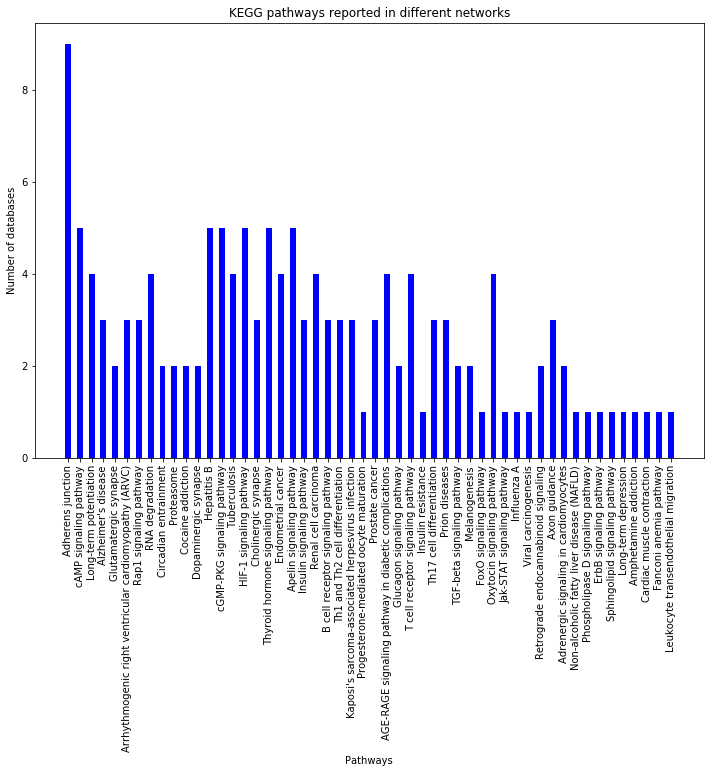

In [12]:
kegg_count = Counter()

for db in databases:
    kegg_count.update(results[db]['Name'])
        
# plot the obtained pathway as a bar chart
fig, ax = plt.subplots(figsize=(12,8))

ind = np.arange(len(kegg_count)) * 2
width = 1

pathways = list(kegg_count.keys())
values = [kegg_count[p] for p in pathways]
bars  = ax.bar(ind, values, width, color='b')

ax.set_title('KEGG pathways reported in different networks')
ax.set_xlabel('Pathways')
ax.set_ylabel('Number of databases')
ax.set_xticks(ind)
ax.set_xticklabels(pathways, rotation=90)

plt.show()
    

The above figure shows that only the `Adherens junction` pathway can be reproduced by all networks (except ComPPI). Therefore, to ensure the reproducibility of scientific findings, it is advisable to apply the same data analysis using as much networks as possible, or using the integrated version of the available networks. Furthermore, the resulted network must be made available to all researchers.